**The purpose of this notebook is to present ways in which we can compare multiple statistical learning approaches for a dataset**
- For simplicity, I will use a toy dataset (breast cancer classification problem) from sklearn.
- I will write a function that outputs a DataFrame that contains k estimated test error/accuracy (from CV) for each of the 6 models.
- Next I will bootstrap 30 samples of the CV performance measures (time and fit) for each of the 6 models.
- I will use data visualization to compare the average performance measures (time and fit) across the models.

**I will also write another function that (in a compact way) perform GridSearch on multiple models**
- Create a pipeline that standardize the train data, then optimize and fit the model with GridSearchCV
- Get a list of "optimized" models 
- Compare the optimized models and choose the "best" statistical learning approach based on highest AUC score (on the test dataset)

In [161]:
'''data'''
import pandas as pd
import numpy as np
from scipy import stats
import itertools
from sklearn.pipeline import Pipeline

'''plots'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

'''models'''
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_validate 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier

'''metrics'''
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, auc, classification_report


## Import Data

In [75]:
from sklearn.datasets import load_breast_cancer

In [162]:
feature_names=load_breast_cancer()['feature_names'] # Get the feature names of the dataset

In [163]:
X, y = data = load_breast_cancer(return_X_y=True)  # Features and response variables

In [164]:
X.shape, y.shape

((569, 30), (569,))

## Train-Test Split

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=10)

## Modelling

This function outputs the classification report of each of the 6 models, and a DataFrame that contains the individual cv scores (5 folds) for each of the 6 models.

In [166]:
# A list of tuples that contains the estimator objects and their names
models = [('LogReg', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('gnb',GaussianNB()),
          ('SVM', SVC()),          
          ('rf', RandomForestClassifier()),
          ('xgb', XGBClassifier())]

In [167]:
''' Run models and find the model with the best performance'''
def run_models (X_train: pd.DataFrame,
                y_train: pd.DataFrame,
                X_test: pd.DataFrame,
                y_test: pd.DataFrame,
                models) ->pd.DataFrame:
    
    # contains a list of DataFrames of CV results of each classifier
    dfs = []
    
    scoring = ['accuracy', 'f1_weighted', 'roc_auc']  # use three different scoring methods
    
    for name, model in models: # model name and model objects
        
        # Get the estimated test error (from CV)
        this_cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 10) 
        # cv_results is an array of and array of scores from the 5 CV for each of the 6 models
        cv_results = cross_validate(model, X_train, y_train, cv=this_cv, scoring=scoring)
        
        # Prediction and test error (on test dataset)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Classification report
        print(name)
        print(classification_report(y_test,y_pred))
        
        # Create a list of DataFrames that contains cv_results
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    # Final DataFrame that contains the cv_results of the 6 models
    final = pd.concat(dfs, ignore_index=True)
    return final

In [168]:
models_cv_results = run_models(X_train, y_train, X_test, y_test, models)

C:\Users\henry_dw8mcdk\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\henry_dw8mcdk\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

LogReg
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        39
           1       0.96      0.93      0.95        75

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.92       114
weighted avg       0.93      0.93      0.93       114

KNN
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        39
           1       0.93      0.95      0.94        75

    accuracy                           0.92       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114

gnb
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        39
           1       0.99      0.95      0.97        75

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

SVM


**Bootstrap 30 samples for the performance metrics (from CV) for each of the 6 models**

In [171]:
models_cv_results.head(10)

,fit_time,score_time,test_accuracy,test_f1_weighted,test_roc_auc,model
0,0.045969,0.004000,0.934307,0.934425,0.991855,LogReg
1,0.041975,0.002999,0.934307,0.932846,0.994796,LogReg
2,0.034981,0.002997,0.912409,0.912976,0.984842,LogReg
3,0.046973,0.006996,0.941606,0.941109,0.988235,LogReg
4,0.034981,0.003997,0.905109,0.902381,0.977376,LogReg
5,0.003995,0.016989,0.934307,0.934425,0.959842,KNN
6,0.002999,0.016990,0.912409,0.912059,0.946154,KNN
7,0.002998,0.017990,0.934307,0.933901,0.965950,KNN
8,0.002998,0.015992,0.905109,0.903562,0.946833,KNN
9,0.001999,0.014996,0.919708,0.917399,0.929186,KNN


In [172]:
bootstrapped_metrics = []
for model in list(models_cv_results.model.unique()):
    # Bootstrap 30 samples for the performance metrics for EACH sample
    mdl = models_cv_results.loc[models_cv_results["model"]== model]
    # sample with replacement (generate 30 samples) for each model
    # From 5 metric (CV) of each model, I have now 30 samples
    bootstrapped_metric = mdl.sample(n=30, replace= True)
    bootstrapped_metrics.append(bootstrapped_metric) 
bootstrapped_metrics = pd.concat(bootstrapped_metrics, ignore_index=True)

In [175]:
# bootstrapped_metrics is a DataFrame that contains the time and performance metrics of the 6 models.
# Each model contains 30 bootstrapped performance and time metrics
# The DataFrame has 30*6= 180 rows
bootstrapped_metrics.head() 

,fit_time,score_time,test_accuracy,test_f1_weighted,test_roc_auc,model
0,0.034981,0.002997,0.912409,0.912976,0.984842,LogReg
1,0.041975,0.002999,0.934307,0.932846,0.994796,LogReg
2,0.034981,0.002997,0.912409,0.912976,0.984842,LogReg
3,0.045969,0.004000,0.934307,0.934425,0.991855,LogReg
4,0.034981,0.003997,0.905109,0.902381,0.977376,LogReg


In [176]:
bootstrapped_metrics.tail()

,fit_time,score_time,test_accuracy,test_f1_weighted,test_roc_auc,model
175,0.100941,0.004001,0.956204,0.956357,0.985294,xgb
176,0.093945,0.004019,0.934307,0.933901,0.963914,xgb
177,0.088949,0.003997,0.948905,0.948806,0.989819,xgb
178,0.092926,0.005997,0.934307,0.934180,0.986199,xgb
179,0.100941,0.004001,0.956204,0.956357,0.985294,xgb


In [178]:
# Put the above DataFrame in long format
long_df = pd.melt(bootstrapped_metrics,id_vars=['model'],var_name='metrics', value_name='values')

In [179]:
long_df

,model,metrics,values
0,LogReg,fit_time,0.034981
1,LogReg,fit_time,0.041975
2,LogReg,fit_time,0.034981
3,LogReg,fit_time,0.045969
4,LogReg,fit_time,0.034981
...,...,...,...
895,xgb,test_roc_auc,0.985294
896,xgb,test_roc_auc,0.963914
897,xgb,test_roc_auc,0.989819
898,xgb,test_roc_auc,0.986199


In [181]:
# The time metrics of a model are rows where metric = "fit_time" or "score_time" 
time_metrics = ['fit_time','score_time']

In [182]:
# Time metrics df
df_time = long_df.loc[long_df['metrics'].isin(time_metrics)] 
df_time = df_time.sort_values(by='values')

In [183]:
# Fit performance metrics df
df_perf = long_df.loc[~long_df['metrics'].isin(time_metrics)] 
df_perf = df_perf.sort_values(by='values')

**Plot the fit performance metric of each model for comparison (boxplots)**

Text(0.5, 1.0, 'Time metric comparison of models')

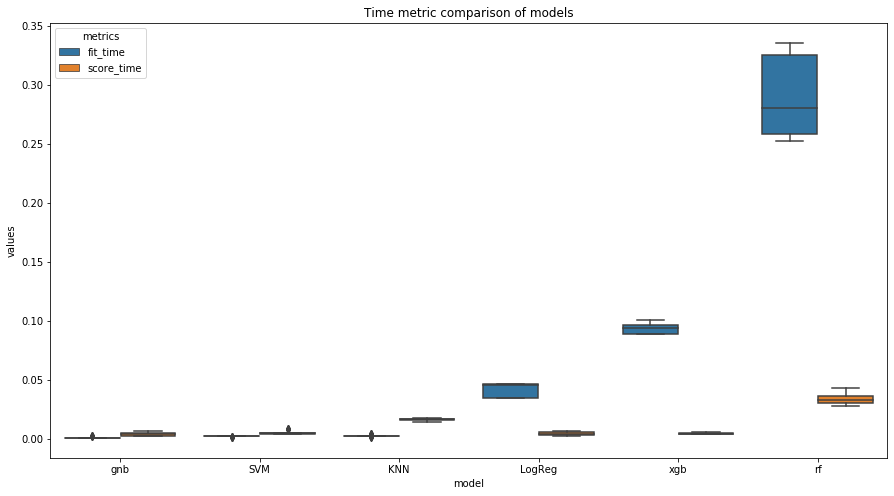

In [184]:
plt.figure(figsize=(15, 8))
p1= sns.boxplot(x="model", y="values", hue="metrics", data=df_time)
plt.title('Time metric comparison of models')

Text(0.5, 1.0, 'Fit performance metric comparison of models')

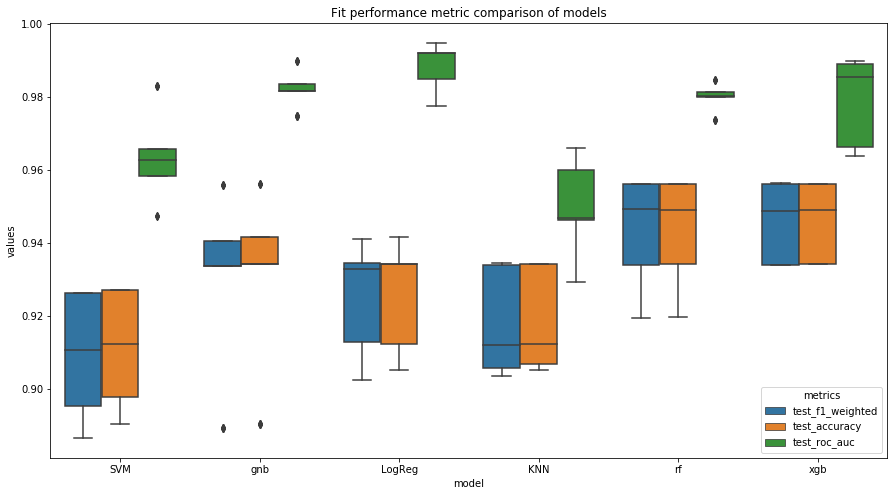

In [17]:
plt.figure(figsize=(15, 8))
p1= sns.boxplot(x="model", y="values", hue="metrics", data=df_perf)
plt.title('Fit performance metric comparison of models')

**Thoughts**
- Logreg, Rf and XGboost have great fit performance, SVM have the worst fit performance for all metrics.  Not surpirsingly, XGBoost and RF takes the longest to train.

**Compute the mean metrics for each model**

In [185]:
metrics = ['test_f1_weighted', 'test_accuracy', 'test_roc_auc']

In [186]:
bootstrapped_metrics.groupby(['model'])[metrics].agg([np.std, np.mean])

test_f1_weighted           test_accuracy           test_roc_auc  \
                    std      mean           std      mean          std   
model                                                                    
KNN            0.012332  0.919185      0.011891  0.919951     0.011416   
LogReg         0.014627  0.927134      0.014132  0.927737     0.005516   
SVM            0.016735  0.909724      0.015496  0.911679     0.012571   
gnb            0.026652  0.927274      0.026334  0.927981     0.005836   
rf             0.010897  0.949743      0.010798  0.949878     0.004629   
xgb            0.009249  0.947086      0.009130  0.947202     0.009735   

                  
            mean  
model             
KNN     0.950064  
LogReg  0.987602  
SVM     0.963793  
gnb     0.982112  
rf      0.981870  
xgb     0.981361

**In a real project, I might only care about the mean precision or recall of ONE of the classes, rather than the mean f1_score (which is an aggregate measure of precision and recall across all classes).**

## GridSearchCV for multiple models
- Write a function that performs GridSearchCV to optimize multiple models

In [205]:
'''data'''
import pandas as pd
import numpy as np
from scipy import stats
import itertools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

'''plots'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

'''models'''
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_validate 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

'''metrics'''
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, auc, classification_report


**Import data**

In [206]:
from sklearn.datasets import load_breast_cancer
feature_names=load_breast_cancer()['feature_names'] # Get the feature names of the dataset
X, y = data = load_breast_cancer(return_X_y=True)  # Features and response variables

# Test Harness
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=10)

**I only train two models: Logistic Regression and Random Forest**

In [207]:
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier()
}

In [208]:
# Use a dictionary of dictionaries to set grid params for logreg and rf
params = {
    'LogisticRegression':  {
        "solver": ['newton-cg', 'sag', 'lbfgs'],
        "multi_class": ['ovr', 'multinomial']
        },
    
    'RandomForestClassifier':  { 
        "n_estimators" : [100, 200, 500, 1000],
        "max_features"      : ["auto", "sqrt", "log2"],
        "criterion": ['gini', 'entropy'],
    }   
}

**GridSearchCV**

In [209]:
from sklearn.model_selection import GridSearchCV

In [210]:
def fit_assess(X_train, y_train):
    """ 
    Fit a list of models with the training data one at a time and obtain 
    models with the best parameters (have the lowest test error from CV)
    """
    best_estimators = [] # a list of "best" estimators: a best logreg and a best rf
    
    for name in models.keys():
        est = models[name]  # initial model object
        est_params = params[name] # parameters for the model
        gscv = GridSearchCV(estimator=est, 
                            param_grid=est_params, 
                            cv=5,
                            verbose = 2,
                            n_jobs=-1)  #GridSearchCV model
        gscv.fit(X_train, y_train)
        print("The best parameters are: {}".format(gscv.best_params_))
        
        best_estimators.append(gscv.best_estimator_)

    return best_estimators

In [211]:
best_models=fit_assess(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished


The best parameters are: {'multi_class': 'multinomial', 'solver': 'newton-cg'}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


The best parameters are: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}


## Standardize data and perform GridSearchCV on multiple models

In [212]:
#I have two statistical learning approaches: LogReg and RF
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier()
}

In [213]:
# Use a dictionary of dictionaries to set the param grid for each of the models
params = {
    'LogisticRegression':  {
        "clf__solver": ['newton-cg', 'sag', 'lbfgs'],
        "clf__multi_class": ['ovr', 'multinomial']
        },
    
    'RandomForestClassifier':  { 
        "clf__n_estimators" : [100, 200, 500, 1000],
        "clf__max_features"      : ["auto", "sqrt", "log2"],
        "clf__criterion": ['gini', 'entropy'],
    }   
}

In [214]:
def fit_assess_pipeline(X_train, y_train):
    """ 
    fits the list of models with the training data one at a time and obtain 
    the "best" test error (from CV) for each model
    """
    gscvs = [] # a list of trained GridSearchCV objects
    
    for name in models.keys():
        pipeline = Pipeline([('scl',StandardScaler()),
                             ('clf', models[name])])  # pipeline for the model    
        est_params = params[name] # parameters for that model
        gscv = GridSearchCV(estimator=pipeline, 
                            param_grid=est_params, 
                            cv=5,
                            verbose = 2,
                            n_jobs=-1)  #GridSearchCV model
        gscv.fit(X_train, y_train)
        print("The best parameters are: {}".format(gscv.best_params_))
        
        gscvs.append(gscv)
    return gscvs

In [215]:
gridSearchObjs=fit_assess_pipeline(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The best parameters are: {'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg'}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished


The best parameters are: {'clf__criterion': 'entropy', 'clf__max_features': 'sqrt', 'clf__n_estimators': 500}


**Take a look at the optimized logistic regression model**

In [216]:
lr_pipeline_optim=gridSearchObjs[0]

In [217]:
# Call predict on the estimator with the best found parameters
y_pred = lr_pipeline_optim.predict(X_test)

In [218]:
# The "long way" would be to get the estimator with the best parameters 
# (with the highest estimated test score, or the lowest estimated test error from CV)
# And then call predict on that estimator
y_pred= lr_pipeline_optim.best_estimator_.predict(X_test)

In [219]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        75

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



**Take a look at "important features" of the random forest model, use "named_steps" to access to "clf" in the pipeline object**

In [220]:
# Use named_steps to have access to "clf" in the pipeline object
rf_pipeline_optim = gridSearchObjs[1]
rf_optim = rf_pipeline_optim.best_estimator_.named_steps['clf']
feature_importance = pd.DataFrame({'feature':list(feature_names),
                                  'importance': rf_optim.feature_importances_})

In [221]:
feature_importance.sort_values('importance', ascending=False).reset_index(drop=True).head(10)

,feature,importance
0,worst concave points,0.131302
1,worst perimeter,0.117413
2,worst area,0.116128
3,mean concave points,0.105584
4,worst radius,0.091847
5,mean concavity,0.050422
6,area error,0.042826
7,mean area,0.042614
8,mean perimeter,0.041376
9,worst concavity,0.037779


**Armed with the optimized models from GridSearchCV, I can choose the "best" statistical learning approach based on highest AUC score (on the test dataset)**

In [222]:
best_roc_auc=0
best_gs = ''

for i, gs in enumerate(gridSearchObjs):
    
    # Get best parameters
    print("\n")
    print(list(models.keys())[i])
    print("Best parameters are: {}".format(gs.best_params_))
     # Best estimated test error (CV)
    print("Estimated test accuracy (from CV) of the model with the best parameters: {}".format(gs.best_score_))
    
    # test predictions 
    y_pred = gs.predict(X_test)
    
    print("AUC score of the model with the best parameters (on the test dataset): {}".format(roc_auc_score(y_test,y_pred)))
    
    # Get the best statistical learning approach
    if roc_auc_score(y_test,y_pred) >= best_roc_auc:
        best_roc_auc = roc_auc_score(y_test,y_pred)  # update best rmse score
        best_gs = gs  # update the best statistical learning approach
        

print("\n The best statistical learning approach (on the test dataset) is {}".format(list(models.keys())[i]))



LogisticRegression
Best parameters are: {'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg'}
Estimated test accuracy (from CV) of the model with the best parameters: 0.9806862288464524
AUC score of the model with the best parameters (on the test dataset): 1.0


RandomForestClassifier
Best parameters are: {'clf__criterion': 'entropy', 'clf__max_features': 'sqrt', 'clf__n_estimators': 500}
Estimated test accuracy (from CV) of the model with the best parameters: 0.9683744760130415
AUC score of the model with the best parameters (on the test dataset): 1.0

 The best statistical learning approach (on the test dataset) is RandomForestClassifier
